In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/digit-recognizer/sample_submission.csv
/kaggle/input/digit-recognizer/train.csv
/kaggle/input/digit-recognizer/test.csv


In [2]:
#Deep learning libraries

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torchvision.utils import make_grid

import math
import random

from PIL import Image, ImageOps, ImageEnhance
import numbers

import matplotlib.pyplot as plt

In [3]:
#set random seeds
np.random.seed(27)
torch.manual_seed(27)

In [4]:
# Get device for training
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cpu device


In [5]:
#loading the data

class MNIST_data(Dataset):
    def __init__(self, filepath, transform = transforms.Compose([transforms.ToTensor,
                                                               transforms.Normalize(mean=(0.5,), std=(0.5,))])):
        #data loading
        df = pd.read_csv(filepath)
        if len(df.columns) == 784:
            self.X = df.values.reshape(-1,28,28).astype(np.float32)[:,None,:,:]
            self.y = None
        else:
            self.X = df.iloc[:,1:].values.reshape(-1,28,28).astype(np.float32)[:,None,:,:]
            self.y = torch.from_numpy(df.iloc[:,0].values)
        self.n_samples = df.shape[0]
        self.transform = transform
        
    def __getitem__(self, index):
        #dataset indexing.
        if self.y is not None:
            return self.X[index], self.y[index]
        else:
            return self.X[index]
        
    def __len__(self):
        #len(dataset)
        return len(self.X)

    def TrainValSplit(self, split):
        split_idx = int(self.n_samples*split)
        return torch.utils.data.random_split(self, [split_idx, self.n_samples - split_idx])

train_dataset = MNIST_data("/kaggle/input/digit-recognizer/train.csv")
test_dataset = MNIST_data("/kaggle/input/digit-recognizer/test.csv")

t_data, v_data = train_dataset.TrainValSplit(0.8)

#testing code
features, labels = train_dataset[0]
print(features.shape)
print(labels)
print(labels.ndimension())
print(len(v_data))

(1, 28, 28)
tensor(1)
0
8400


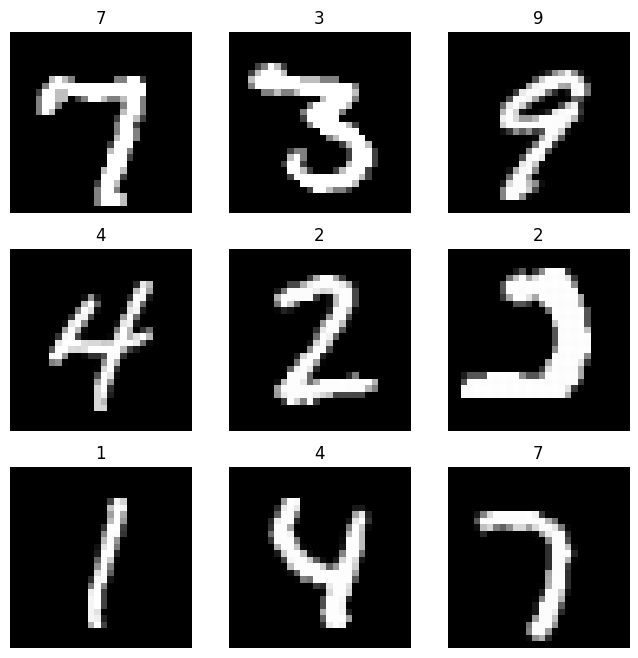

In [6]:
# visualise some examples
import matplotlib.pyplot as plt

# Assuming `training_data` is already defined as a PyTorch dataset
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3

for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(100, size=(1,)).item()
    img, label = train_dataset[sample_idx]
    
    figure.add_subplot(rows, cols, i)
    plt.title(str(label)[7])
    plt.axis("off")
    plt.imshow(img.reshape(28, 28), cmap="gray")  
    
plt.show()

In [7]:
# calling the data loader
train_dataloader = DataLoader(t_data, batch_size = 1024, shuffle = True)
valid_dataloader = DataLoader(v_data, batch_size = 1024, shuffle = True)
test_dataloader = DataLoader(test_dataset, batch_size = 1024, shuffle = False)

print(valid_dataloader)

In [8]:
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")

Feature batch shape: torch.Size([1024, 1, 28, 28])
Labels batch shape: torch.Size([1024])


In [9]:
# structure of the neural network
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        #self.flatten = nn.Flatten()
        self.relu_layer = nn.ReLU()
        self.dense_1 = nn.Linear(28*28,20)
        self.dense_2 = nn.Linear(20,15)
        self.dense_output = nn.Linear(15,10)

    def forward(self, x):
        x = self.relu_layer(self.dense_1(x))
        x = self.relu_layer(self.dense_2(x))
        logits = self.dense_output(x); return logits
print(NeuralNetwork)

<class '__main__.NeuralNetwork'>


In [41]:
# structure of the convolutional neural network
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
        self.conv_1_batchnorm = nn.BatchNorm2d(16)
        self.conv_2 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.conv_2_batchnorm = nn.BatchNorm2d(8)
        self.dense_1 = nn.Linear(8*7*7, 20)
        self.dense_output = nn.Linear(20, 10)

    def forward(self, x):
        x = self.conv_1_batchnorm(self.conv_1(x))
        x = F.max_pool2d(torch.relu(x), 2)
        x = self.conv_2_batchnorm(self.conv_2(x))
        x = F.max_pool2d(torch.relu(x), 2)
        x = x.view(-1, 8*7*7)
        x = torch.relu(self.dense_1(x))
        logits = self.dense_output(x)
        return logits
print(CNN)

<class '__main__.CNN'>


In [42]:
# model hyperparameters
epochs = 50
batch_size = 1024
learning_rate = 0.001

In [43]:
# instance of the NN
model = CNN()

model.to(device)

optimizer = optim.Adam(model.parameters(), lr = learning_rate)

print(model)

CNN(
  (conv_1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_1_batchnorm): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_2): Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_2_batchnorm): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dense_1): Linear(in_features=392, out_features=20, bias=True)
  (dense_output): Linear(in_features=20, out_features=10, bias=True)
)


In [44]:
# define cel and accuracy
def cel(y_true, y_pred):
    y_true = y_true.long().squeeze()
    return nn.CrossEntropyLoss()(y_pred, y_true)

def acc(y_true, y_pred):
    y_true = y_true.long().squeeze()
    y_pred = torch.argmax(y_pred, axis=1)
    return (y_true == y_pred).float().sum()/len(y_true)

In [45]:
#training loop
train_losses, valid_losses = [], []
train_accuracies, valid_accuracies = [], []

for epoch in range(epochs):
    model.train()
    print(f"Epoch: {epoch + 1}")
    batch_train_losses, batch_train_accuracies = [], []

    batch = 0
    for train_batch in train_dataloader:
        train_X, train_y = train_batch
        train_preds = model(train_X)
        train_loss = cel(train_y, train_preds)
        train_accuracy = acc(train_y, train_preds)

        optimizer.zero_grad()
        train_loss.backward()

        optimizer.step()
        train_loss = np.round(train_loss.item(), 3)
        train_accuracy = np.round(train_accuracy.item(), 3)

        batch += 1
        log = batch % 10 == 0

        batch_train_losses.append(train_loss)
        batch_train_accuracies.append(train_accuracy)

        if log: print(f"""Batch: {batch} || Train Loss: {train_loss} 
                        || Train Acc: {train_accuracy}""")

    train_losses.append(np.mean(batch_train_losses))
    train_accuracies.append(np.mean(batch_train_accuracies))

    total_valid_loss, total_valid_points, total_valid_accuracy = 0, 0, 0

    with torch.no_grad():
        for valid_batch in valid_dataloader:
            valid_X, valid_y = valid_batch

            valid_preds = model.forward(valid_X)
            valid_loss = cel(valid_y, valid_preds)
            valid_accuracy = acc(valid_y, valid_preds)

            total_valid_points += 1
            total_valid_loss += valid_loss.item()
            total_valid_accuracy += valid_accuracy.item()

        valid_loss = np.round(total_valid_loss/total_valid_points, 3)
        valid_accuracy = np.round(total_valid_accuracy/total_valid_points, 3)

        valid_losses.append(valid_loss)
        valid_accuracies.append(valid_accuracy)
        
        print(f"""Epoch: {epoch + 1} || Valid Loss: {valid_loss} || Valid Acc: {valid_accuracy}""")
        

Epoch: 1
Batch: 10 || Train Loss: 1.808 
                        || Train Acc: 0.519
Batch: 20 || Train Loss: 1.345 
                        || Train Acc: 0.673
Batch: 30 || Train Loss: 0.979 
                        || Train Acc: 0.798
Epoch: 1 || Valid Loss: 0.831 || Valid Acc: 0.836
Epoch: 2
Batch: 10 || Train Loss: 0.618 
                        || Train Acc: 0.861
Batch: 20 || Train Loss: 0.475 
                        || Train Acc: 0.887
Batch: 30 || Train Loss: 0.363 
                        || Train Acc: 0.908
Epoch: 2 || Valid Loss: 0.358 || Valid Acc: 0.909
Epoch: 3
Batch: 10 || Train Loss: 0.32 
                        || Train Acc: 0.916
Batch: 20 || Train Loss: 0.252 
                        || Train Acc: 0.932
Batch: 30 || Train Loss: 0.222 
                        || Train Acc: 0.951
Epoch: 3 || Valid Loss: 0.236 || Valid Acc: 0.938
Epoch: 4
Batch: 10 || Train Loss: 0.211 
                        || Train Acc: 0.949
Batch: 20 || Train Loss: 0.189 
                       

In [46]:
#prediction on test set
def softmax(x):
    return np.exp(x)/np.sum(np.exp(x), axis=1)[:,None]

test_preds = []
with torch.no_grad():
    for test_X in test_dataloader:
        test_pred = model.forward(test_X)
        test_preds.append(softmax(test_pred.detach().numpy()))


In [47]:
submission = pd.read_csv("../input/digit-recognizer/sample_submission.csv")
submission["Label"] = np.argmax(np.concatenate(test_preds, axis=0), axis=1)

In [48]:
submission.to_csv('submission.csv', index=False)

In [49]:
submission.head()

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,0
4,5,3
